In [33]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"])

import torch
device_name = torch.cuda.get_device_name(0)
for i in range(torch.cuda.device_count()):
    props = torch.cuda.get_device_properties(i)
    print(f"Logical index: {i}, Name: {props.name}")

CUDA_VISIBLE_DEVICES: 1
Logical index: 0, Name: NVIDIA GeForce RTX 2080 Ti


In [34]:
%cd /home/is/dwipraseetyo-a/NAS_HAI/Project/Qwen2.5-Omni
%pwd

/home/ldap-users-2/dwipraseetyo-a/Project/Qwen2.5-Omni


/home/is/dwipraseetyo-a/ven2/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/ldap-users-2/dwipraseetyo-a/Project/Qwen2.5-Omni'

In [35]:
import pickle, os
from PIL import Image
from tqdm import tqdm
import numpy as np
import pickle
import librosa

import torch
from torch.utils.data import Dataset
from transformers import TrainingArguments, Qwen2_5OmniThinkerForConditionalGeneration, Qwen2_5OmniProcessor
from peft import prepare_model_for_kbit_training, get_peft_model, LoraConfig, TaskType
from trl import SFTTrainer
from qwen_omni_utils import process_mm_info

from transformers import Trainer, TrainingArguments, BitsAndBytesConfig
from datetime import datetime
from trl import SFTTrainer, SFTConfig

import torch
import torch.nn.functional as F

In [36]:
def load_image_PIL(loaded_object):
    for obj in tqdm(loaded_object):
        for message in obj.get("messages", []):
            for content in message.get("content", []):
                if isinstance(content, dict) and "image" in content:
                    array = np.load(content["image"])
                    array_min = array.min()
                    array_max = array.max()
                    if array_max != array_min:
                        array_norm = (array - array_min) / (array_max - array_min)
                    else:
                        array_norm = np.zeros_like(array)
                    array_uint8 = (array_norm * 255).astype(np.uint8)
                    mask = array_uint8 != 253
                    coords = np.argwhere(mask)
                    if coords.size == 0:
                        cropped_array = array_uint8
                    else:
                        y0, x0 = coords.min(axis=0)
                        y1, x1 = coords.max(axis=0) + 1
                        cropped_array = array_uint8[y0:y1, x0:x1]
                    array_PIL = Image.fromarray(cropped_array)
                    content["image"] = array_PIL
    return loaded_object

class QwenOmniFinetuneDataset(Dataset):
    def __init__(self, data, processor, use_audio_in_video=False):
        self.data = data
        self.processor = processor
        self.use_audio_in_video = use_audio_in_video

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        conversation = self.data[idx]["messages"]
        return conversation

def collate_fn(conversations):
    text =  [processor.apply_chat_template(conversation, tokenize=False) for conversation in conversations]
    audios, images, videos = process_mm_info(conversations, use_audio_in_video=False)
    batch = processor(text=text, audio=audios, images=images, videos=videos, 
                            return_tensors="pt", padding=True, use_audio_in_video=False)
    
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100

    # Ignore the image token index in the loss computation (model specific)
    image_tokens = [151652, 151653, 151655] # image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]
    audio_tokens = [151647, 151648, 151646]

    # Mask image token IDs in the labels
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    for audio_token_id in audio_tokens:
        labels[labels == audio_token_id] = -100  # Mask image token IDs in labels

    #inputs['use_audio_in_video']
    batch["labels"] = labels
    return batch

In [43]:
processor = Qwen2_5OmniProcessor.from_pretrained("Qwen/Qwen2.5-Omni-7B")

with open('/home/is/dwipraseetyo-a/NAS_HAI/Datasets/cidrz/instruct.pkl.test', 'rb') as f:
    test_instruct = load_image_PIL(pickle.load(f))

test_dataset = QwenOmniFinetuneDataset(test_instruct, processor, use_audio_in_video=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [01:00<00:00,  8.15it/s]


In [1]:
conversation = test_dataset[5]
text = processor.apply_chat_template(conversation, tokenize=False) # add_generation_prompt?
audios, images, videos = process_mm_info(conversation, use_audio_in_video=False)
batch = processor(text=text, audio=audios, images=images, videos=videos, 
                        return_tensors="pt", padding=True, use_audio_in_video=False)

NameError: name 'test_dataset' is not defined

In [51]:
print(text)

<|im_start|>system
You are an advanced medical assistant AI specialized in analyzing and diagnosing clinical conditions. You can interpret and reason over multimodal inputs, including cough sounds, medical images (e.g., chest X-rays), and patient metadata. Your task is to analyze the given information, explain your reasoning clearly, and provide possible diagnoses based on medical understanding. Support your conclusions with observations from the input data whenever possible, and maintain clinical accuracy and clarity in your responses.<|im_end|>
<|im_start|>user
What disease might be inferred from this radiographic image and the patient's cough sound?. The additional patient data are: chestpain is yes, cigarretes_perday is Unknown, hiv_status is pos, tobacco_use is never, coughdur is <1wk.  And The additional metadata x-ray image: Modality is DX, DistanceSourceToDetector is 1000.0, FieldOfViewDimensions is [350, 425], ImagerPixelSpacing is [0.15, 0.15], TargetExposureIndex is 876.0, S

In [52]:
from IPython.display import Audio
import matplotlib.pyplot as plt

In [53]:
Audio(audios[0], rate=16000)

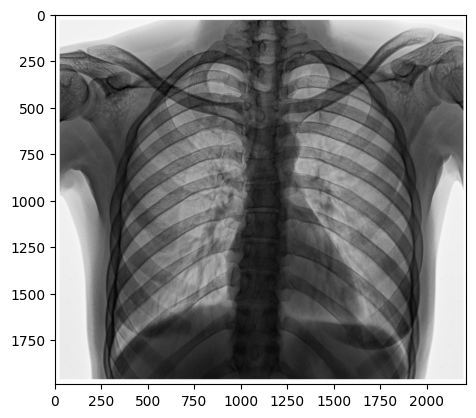

In [54]:
plt.imshow(images[0])
plt.show()

In [29]:
collate_data = collate_fn([test_dataset[0]])
list(collate_data.keys())

['input_ids',
 'attention_mask',
 'pixel_values',
 'image_grid_thw',
 'feature_attention_mask',
 'input_features',
 'labels']

In [ ]:
import soundfile as sf

from transformers import Qwen2_5OmniForConditionalGeneration, Qwen2_5OmniProcessor
from qwen_omni_utils import process_mm_info

# default: Load the model on the available device(s)
#model = Qwen2_5OmniForConditionalGeneration.from_pretrained("Qwen/Qwen2.5-Omni-7B", torch_dtype="auto", device_map="auto")

# We recommend enabling flash_attention_2 for better acceleration and memory saving.
model = Qwen2_5OmniForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-Omni-7B",
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="flash_attention_2",
)
model.disable_talker()
processor = Qwen2_5OmniProcessor.from_pretrained("Qwen/Qwen2.5-Omni-7B")

In [ ]:
import soundfile as sf

from transformers import Qwen2_5OmniForConditionalGeneration, Qwen2_5OmniProcessor
from qwen_omni_utils import process_mm_info

# default: Load the model on the available device(s)
#model = Qwen2_5OmniForConditionalGeneration.from_pretrained("Qwen/Qwen2.5-Omni-7B", torch_dtype="auto", device_map="auto")

# We recommend enabling flash_attention_2 for better acceleration and memory saving.
model = Qwen2_5OmniForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-Omni-7B",
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="flash_attention_2",
)
model.disable_talker()
processor = Qwen2_5OmniProcessor.from_pretrained("Qwen/Qwen2.5-Omni-7B")
conversation = [
    {
        "role": "system",
        "content": [
            {"type": "text", "text": "You are Qwen, a virtual human developed by the Qwen Team, Alibaba Group, capable of perceiving auditory and visual inputs, as well as generating text."}
        ],
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "https://as1.ftcdn.net/v2/jpg/00/46/68/82/1000_F_46688223_a1wEkSmHRU5yNZYuQxSmbY4BDV7uNido.jpg"},
            {"type": "audio", "audio": "https://cdn.pixabay.com/download/audio/2022/03/14/audio_16ec50efc4.mp3?filename=horrible-female-cough-66368.mp3"},
            {"type": "text", "text": "What are the elements can you see and hear in these medias?"},
        ],
    },
]

# set use audio in video
USE_AUDIO_IN_VIDEO = True

# Preparation for inference
text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
audios, images, videos = process_mm_info(conversation, use_audio_in_video=USE_AUDIO_IN_VIDEO)
inputs = processor(text=text, audio=audios, images=images, videos=videos, return_tensors="pt", padding=True, use_audio_in_video=USE_AUDIO_IN_VIDEO)
inputs = inputs.to(model.device).to(model.dtype)

# Inference: Generation of the output text and audio
text_ids = model.generate(**inputs, use_audio_in_video=USE_AUDIO_IN_VIDEO, return_audio=False)
text = processor.batch_decode(text_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)